In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
import torch.optim as optim

# GPU 사용 가능 여부 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 한글 폰트 설정
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

Using device: cuda


# 데이터 확인

In [3]:
test_dir = 'test'
train_dir = 'train'

# test 폴더에서 5개 파일 출력
test_files = os.listdir(test_dir)[:5]
for file in test_files:
    print(f'- {file}')

# train 폴더에서 5개 파일 출력
train_files = os.listdir(train_dir)[:5]
for file in train_files:
    print(f'- {file}')

- 1.jpg
- 10.jpg
- 100.jpg
- 1000.jpg
- 10000.jpg
- cat.0.jpg
- cat.1.jpg
- cat.10.jpg
- cat.100.jpg
- cat.1000.jpg


# 데이터 정리
- train 폴더 내부를 정리할 필요가 있음
  + cat, dog 파일들로 묶어서 그룹필 할 필요 있음

In [7]:
"""
import os
import shutil

# train 폴더 경로 설정
train_dir = 'train'

# os.path.join(train_dir, 'cat') # train\\cat 경로 설정
os.makedirs(os.path.join(train_dir, 'cat'), exist_ok=True)
os.makedirs(os.path.join(train_dir, 'dog'), exist_ok=True)
"""

In [13]:
"""
for filename in os.listdir(train_dir):
    if filename.endswith('.jpg'):
        # 파일 이름에서 cat/dog 구분
        if filename.startswith('cat'):
            # cat 파일을 cat 폴더로 이동
            src = os.path.join(train_dir, filename)
            dst = os.path.join(train_dir, 'cat', filename)
            shutil.move(src, dst)
        elif filename.startswith('dog'):
            # dog 파일을 dog 폴더로 이동
            src = os.path.join(train_dir, filename)
            dst = os.path.join(train_dir, 'dog', filename)
            shutil.move(src, dst)
"""

- 파일명 변경

In [15]:
"""
import os

# train 폴더 내의 cat과 dog 폴더 경로 설정
train_dir = 'train'
cat_dir = os.path.join(train_dir, 'cat')
dog_dir = os.path.join(train_dir, 'dog')

# cat 폴더 내 파일명 변경
for filename in os.listdir(cat_dir):
    if filename.startswith('cat.'):
        # cat.0.jpg -> cat0.jpg 형식으로 변경
        new_name = filename.replace('cat.', 'cat')
        old_path = os.path.join(cat_dir, filename)
        new_path = os.path.join(cat_dir, new_name)
        os.rename(old_path, new_path)

# dog 폴더 내 파일명 변경
for filename in os.listdir(dog_dir):
    if filename.startswith('dog.'):
        # dog.0.jpg -> dog0.jpg 형식으로 변경
        new_name = filename.replace('dog.', 'dog')
        old_path = os.path.join(dog_dir, filename)
        new_path = os.path.join(dog_dir, new_name)
        os.rename(old_path, new_path)

print("파일명 변경이 완료되었습니다.")
"""

파일명 변경이 완료되었습니다.


# 이미지 시각화

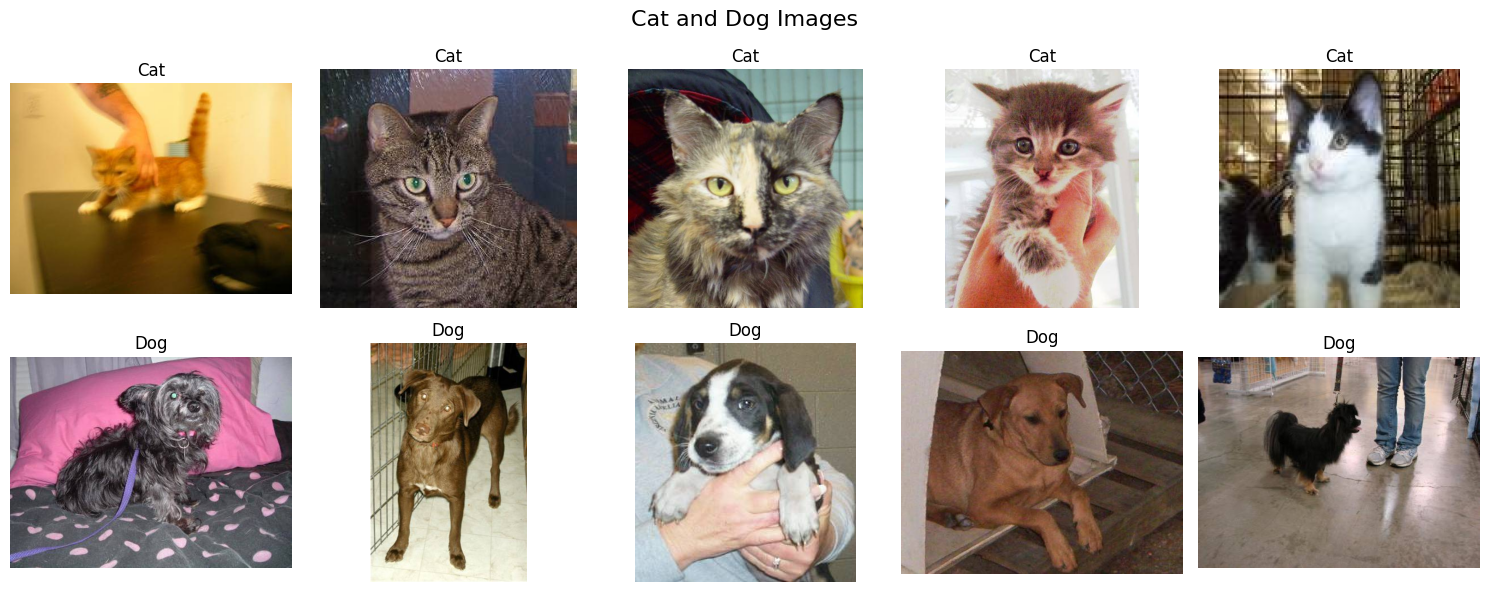

In [2]:
import matplotlib.pyplot as plt
import os
from PIL import Image

# train 폴더 내의 cat과 dog 폴더 경로 설정
train_dir = 'train'
cat_dir = os.path.join(train_dir, 'cat')
dog_dir = os.path.join(train_dir, 'dog')

# print(cat_dir, dog_dir)
# cat과 dog 폴더에서 각각 5개의 이미지 파일 가져오기
cat_files = os.listdir(cat_dir)[:5]
dog_files = os.listdir(dog_dir)[:5]

# 2x5 크기의 figure 생성
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Cat and Dog Images', fontsize=16)

# cat 이미지 표시
for idx, filename in enumerate(cat_files):
    img_path = os.path.join(cat_dir, filename)
    img = Image.open(img_path)
    axes[0, idx].imshow(img)
    axes[0, idx].axis('off')
    axes[0, idx].set_title('Cat')

# dog 이미지 표시
for idx, filename in enumerate(dog_files):
    img_path = os.path.join(dog_dir, filename)
    img = Image.open(img_path)
    axes[1, idx].imshow(img)
    axes[1, idx].axis('off')
    axes[1, idx].set_title('Dog')

plt.tight_layout()
plt.show()

# 데이터 전처리기

## 데이터셋 분류

In [3]:
# Data Leakage 방지
# 훈련데이터/테스트데이터 분리
import shutil
import random

# 원본 데이터 경로
train_dir = 'train'
cat_dir = os.path.join(train_dir, 'cat')
dog_dir = os.path.join(train_dir, 'dog')

# 새로운 데이터셋 경로 생성
train_data_dir = 'train_data'
val_data_dir = 'val_data'

# train_data와 val_data 폴더 내에 cat과 dog 폴더 생성
os.makedirs(os.path.join(train_data_dir, 'cat'), exist_ok=True)
os.makedirs(os.path.join(train_data_dir, 'dog'), exist_ok=True)
os.makedirs(os.path.join(val_data_dir, 'cat'), exist_ok=True)
os.makedirs(os.path.join(val_data_dir, 'dog'), exist_ok=True)

# cat 이미지 파일 리스트
cat_files = os.listdir(cat_dir)
# dog 이미지 파일 리스트
dog_files = os.listdir(dog_dir)

In [4]:
# 무작위로 섞기
random.shuffle(cat_files)
random.shuffle(dog_files)

In [5]:
# 8:2 비율로 분할
cat_train_size = int(len(cat_files) * 0.8)
dog_train_size = int(len(dog_files) * 0.8)

cat_train_size, dog_train_size

(10000, 10000)

In [6]:
# train 데이터 복사
for file in cat_files[:cat_train_size]:
    src = os.path.join(cat_dir, file)
    dst = os.path.join(train_data_dir, 'cat', file)
    shutil.copy2(src, dst)

for file in dog_files[:dog_train_size]:
    src = os.path.join(dog_dir, file)
    dst = os.path.join(train_data_dir, 'dog', file)
    shutil.copy2(src, dst)

# validation 데이터 복사
for file in cat_files[cat_train_size:]:
    src = os.path.join(cat_dir, file)
    dst = os.path.join(val_data_dir, 'cat', file)
    shutil.copy2(src, dst)

for file in dog_files[dog_train_size:]:
    src = os.path.join(dog_dir, file)
    dst = os.path.join(val_data_dir, 'dog', file)
    shutil.copy2(src, dst)

- Train 데이터셋
  + Cat : 10000
  + Dog : 10000
- Validation
  + Cat : 2500
  + Dog : 2500

# 데이터 전처리기 만들기

In [7]:
def preprocess_image(image_path, transform):
    # 데이터 전처리 완료 후, 시각화 할 때 사용 예정
    image = Image.open(image_path).convert('RGB')
    return transform(image)

## Transform 정의
- 대원칙은 Data Leakage 생각
  + Validation은 우리가 모르는 데이터
    - 알고리즘에 적용이 가능한 최소화로 이미지 변형
    - 예를 들면
      + 이미지 사이즈만 변경(필수)
      + 이미지 정규화(훈련데이터와 동일한 형태, 옵션)
  + 데이터 전처리를 위한 모든 코드는 Train 데이터에만 적용

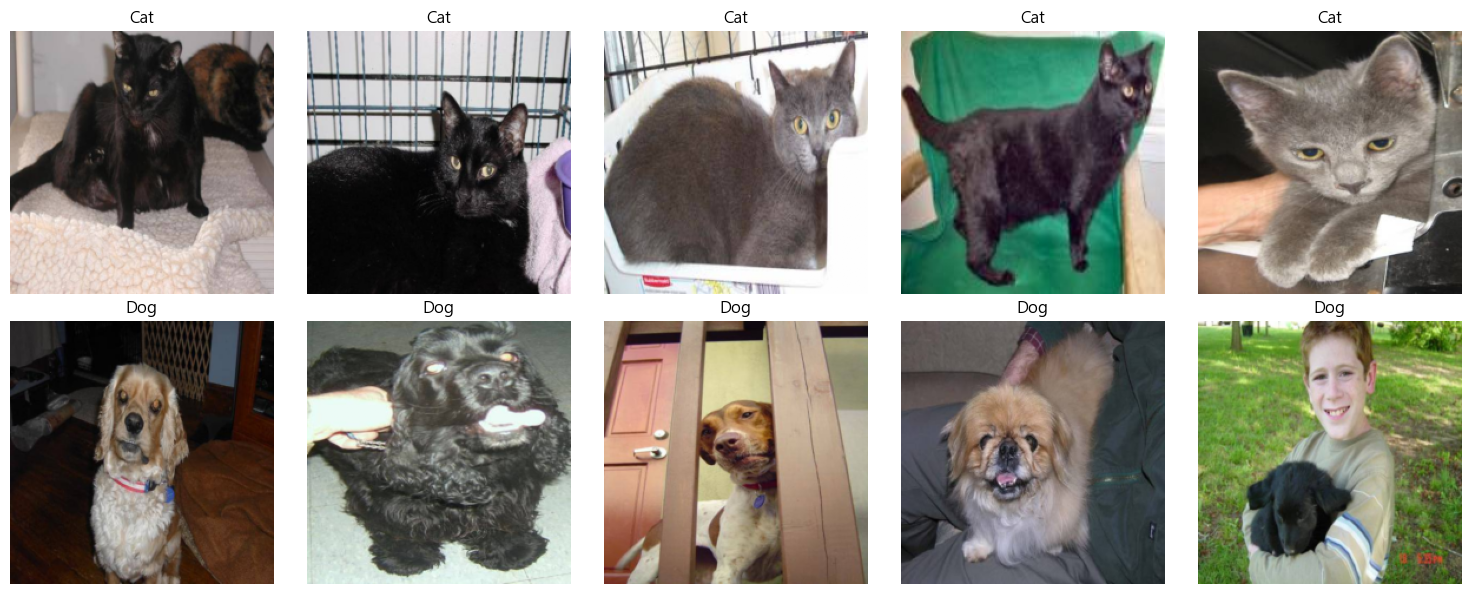

In [11]:
# 데이터 전처리를 위한 transform 정의
# 데이터 증강 이유 : 과적합 방지
train_transform = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.RandomHorizontalFlip(), # 데이터 증강
    transforms.RandomRotation(10), # 데이터 증강
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

# 시각화를 위한 transform (추후에는 검증데이터용으로 활용)
viz_transform = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.ToTensor()
])

# 시각화를 위한 샘플 이미지 선택
sample_cat_files = cat_files[:5]
sample_dog_files = dog_files[:5]

# 시각화를 위한 figure 생성
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

# 고양이 이미지 시각화
for idx, file in enumerate(sample_cat_files):
    img_path = os.path.join(cat_dir, file)
    img = preprocess_image(img_path, viz_transform)
    
    axes[idx].imshow(img.permute(1, 2, 0))
    axes[idx].set_title('Cat')
    axes[idx].axis('off')

# 강아지 이미지 시각화
for idx, file in enumerate(sample_dog_files):
    img_path = os.path.join(dog_dir, file)
    img = preprocess_image(img_path, viz_transform)
    
    axes[idx + 5].imshow(img.permute(1, 2, 0))
    axes[idx + 5].set_title('Dog')
    axes[idx + 5].axis('off')

plt.tight_layout()
plt.show()

# 데이터 로더
- 고양이 이미지 가져와서 전처리
- 강아지 이미지 가져와서 전처리
- 배치 사이즈 크기 설정
- 데이터를 무작위로 섞는 작업

## 데이터셋 클래스 정의

In [12]:
class CatDogDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_files = [] # 학습 데이터 
        self.labels = [] # y값

        # 고양이 이미지 불러오기, 라벨 0 지정
        cat_dir = os.path.join(data_dir, 'cat')
        cat_files = os.listdir(cat_dir)
        self.image_files.extend([os.path.join(cat_dir, f) for f in cat_files])
        self.labels.extend([0] * len(cat_files)) # 고양이: 0

        # 강아지 이미지 불러오기, 라벨 1 지정
        dog_dir = os.path.join(data_dir, 'dog')
        dog_files = os.listdir(dog_dir)
        self.image_files.extend([os.path.join(dog_dir, f) for f in dog_files])
        self.labels.extend([1] * len(dog_files)) # 강아지

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        label = self.labels[idx]

        # 이미지 전처리
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return image, label

In [13]:
# 데이터 생성, 데이터 전처리가 완료된 데이터셋
train_dataset = CatDogDataset('train_data', transform=train_transform)
val_dataset = CatDogDataset('val_data', transform=viz_transform)

# 데이터 로더 생성, 학습 알고리즘에 들어갈 형태로 다시 변형
train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=32, 
    shuffle=True, 
    num_workers=0
)

# 데이터 로더 생성, 학습 알고리즘에 들어갈 형태로 다시 변형
val_loader = torch.utils.data.DataLoader(
    val_dataset, 
    batch_size=32, 
    shuffle=False, 
    num_workers=0
)

# 모델링

In [14]:
# timm 라이브러리를 사용하여 EfficientNet 모델 가져오기
import timm
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# EfficientNet-B0 모델 생성
model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=2)

# GPU 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습 시작
num_epochs = 5

# 학습/검증 메트릭 저장을 위한 리스트
train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(num_epochs):
    # 학습 단계
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    print(f'🔁 Epoch {epoch+1}/{num_epochs} - Training')
    with tqdm(train_loader, desc='Train', unit='batch', leave=True) as train_pbar:
        for images, labels in train_pbar:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()
            
            train_pbar.set_postfix({
                'loss': f'{loss.item():.3f}',
                'acc': f'{100.*train_correct/train_total:.2f}%'
            })
    
    # 에포크당 평균 학습 손실과 정확도 계산
    avg_train_loss = train_loss / len(train_loader)
    avg_train_acc = 100. * train_correct / train_total
    train_losses.append(avg_train_loss)
    train_accs.append(avg_train_acc)

    # 검증 단계
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    print(f'📊 Epoch {epoch+1}/{num_epochs} - Validation')
    with torch.no_grad():
        with tqdm(val_loader, desc='Validation', unit='batch', leave=True) as val_pbar:
            for images, labels in val_pbar:
                images, labels = images.to(device), labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
                
                val_pbar.set_postfix({
                    'loss': f'{val_loss/len(val_loader):.3f}',
                    'acc': f'{100.*val_correct/val_total:.2f}%'
                })
    
    # 에포크당 평균 검증 손실과 정확도 계산
    avg_val_loss = val_loss / len(val_loader)
    avg_val_acc = 100. * val_correct / val_total
    val_losses.append(avg_val_loss)
    val_accs.append(avg_val_acc)

🔁 Epoch 1/5 - Training


Train: 100%|██████| 751/751 [03:52<00:00,  3.23batch/s, loss=3.931, acc=93.84%]


📊 Epoch 1/5 - Validation


Validation: 100%|█| 282/282 [01:10<00:00,  3.97batch/s, loss=0.471, acc=73.71%]


🔁 Epoch 2/5 - Training


Train: 100%|██████| 751/751 [02:06<00:00,  5.94batch/s, loss=0.002, acc=93.51%]


📊 Epoch 2/5 - Validation


Validation: 100%|█| 282/282 [00:23<00:00, 12.21batch/s, loss=0.437, acc=75.37%]


🔁 Epoch 3/5 - Training


Train: 100%|██████| 751/751 [02:06<00:00,  5.95batch/s, loss=0.000, acc=96.73%]


📊 Epoch 3/5 - Validation


Validation: 100%|█| 282/282 [00:23<00:00, 12.03batch/s, loss=0.468, acc=72.55%]


🔁 Epoch 4/5 - Training


Train: 100%|██████| 751/751 [02:08<00:00,  5.86batch/s, loss=1.455, acc=97.65%]


📊 Epoch 4/5 - Validation


Validation: 100%|█| 282/282 [00:23<00:00, 12.06batch/s, loss=0.409, acc=78.90%]


🔁 Epoch 5/5 - Training


Train: 100%|█████| 751/751 [02:07<00:00,  5.89batch/s, loss=12.680, acc=95.50%]


📊 Epoch 5/5 - Validation


Validation: 100%|█| 282/282 [00:23<00:00, 11.91batch/s, loss=0.580, acc=73.16%]


## 모델 학습 확인

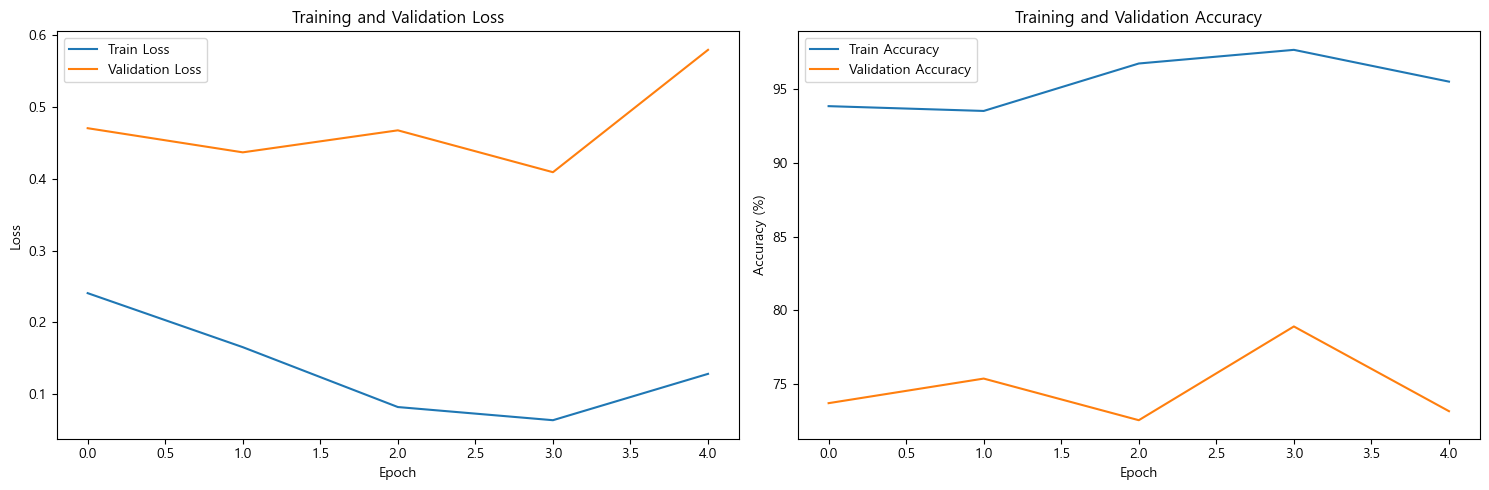

In [15]:
# 학습 결과 시각화
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# 손실 그래프
ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# 정확도 그래프
ax2.plot(train_accs, label='Train Accuracy')
ax2.plot(val_accs, label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()

plt.tight_layout()
plt.show()

# 테스트 데이터 적용

In [16]:
import os 
from PIL import Image
import torch 
from torchvision import transforms
from tqdm import tqdm # 진행률 라이브러리
from datetime import datetime

# 테스트용 transform 정의 
test_transform = transforms.Compose([
    transforms.Resize([224, 224]), 
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

# 테스트 데이터 디렉터리 
test_dir = 'test'
test_files = os.listdir(test_dir)

# submission 파일명 생성 
now = datetime.now()
timestamp = now.strftime("%Y%m%d_%H%M%S")
submission_file = f'submission_{timestamp}.csv'
submission_file

# 예측 및 저장 
with open(submission_file, 'w') as f:
    f.write('id,label\n')

    model.eval()
    with torch.no_grad():
        for filename in tqdm(test_files, desc='Testing'):
            img_path = os.path.join(test_dir, filename)
            image = Image.open(img_path).convert('RGB')
            image = test_transform(image).unsqueeze(0).to(device) # transform 적용
            outputs = model(image)
            _, predicted = outputs.max(1)
            label = predicted.item()

            id = os.path.splitext(filename)[0]
            f.write(f'{id},{label}\n')

print(f"submission file 생성: {submission_file}")

Testing: 100%|███████████████████████████| 12500/12500 [03:00<00:00, 69.08it/s]

submission file 생성: submission_20250609_121429.csv


# 모델 내보내기

In [17]:
# 모델 저장
model_path = 'cat_dog_model.pth'
torch.save(model.state_dict(), model_path)
print(f'Model saved to {model_path}')

# 모델 구조와 가중치를 함께 저장
full_model_path = 'cat_dog_model_full.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'model_architecture': model,
    'transforms': train_transform
}, full_model_path)
print(f'Full model saved to {full_model_path}')

Model saved to cat_dog_model.pth
Full model saved to cat_dog_model_full.pth
